# Summary

## Dataframes

- **corr_pair.pkl**: dataframe of the correlation information of all ON/OFF pairs.
- **corr_dataframe.pkl**: corr_pair.pkl dataframe, with added ON and OFF target coordinates.
- **comb_corr_hog.pkl**: dataframe of the correlation + HOG (unnormalized) information of ON/OFF pairs.
- **mod_corr_dataframe.pkl**: dataframe of header information and correlation information of all ON/OFF pairs.
- **dataframe.pkl**: dataframes 'comb_corr_hog.pkl' and 'mod_corr_dataframe.pkl' combined

- **binary_dataframe.pkl**: dataframe of the correlation + HOG (binarized) information of ON/OFF pairs.
- **log_dataframe.pkl**: dataframe of the correlation + HOG (log normalized) information.
- **binary_hog_dataframe.pkl**: dataframe of correlation (only aligned) + HOG (unnormalized) + HOG (binarized) information of ON/OFF pairs.
- **binary_log_dataframe.pkl**: dataframe of correlation (only aligned) + HOG (log normalized) + HOG (binarized) information of ON/OFF pairs.
- **log_hog_dataframe.pkl**: dataframe of correlation (only aligned) + HOG (log normalized) + HOG (unnormalized) information of ON/OFF pairs.
- **binary_log_hog_dataframe.pkl**: dataframe of correlation (only aligned) + HOG (binarized) + HOG (log normalized) + HOG (unnormalized) information of ON/OFF pairs.
- **labelled_binary_log_hog_dataframe.pkl**: dataframe of correlation (only aligned) + HOG (binarized) + HOG (log normalized) + HOG (unnormalized) + labels (see Probabilities CSV Jupyter notebook for what the numbers mean) information of ON/OFF pairs. 


## Arrays

- **pairs.npy** contains the correlation information of all the pairs
- **header.npy** contains the header information of all the pairs
    - shape[0]=2, the 0th item is the ON header information; the 1st item is the OFF header information
    - shape[x][0]=4
        - FCNTR
        - RA
        - DEC
        - MJD


- **labelled_files.npy** contains the labels of all the labelled files. Read the Jupyter notebook 'Probabilities CSV' to see how labels were loaded in.

**For everything below, see function hog_fd() to see how bins were shifted**

- **hog_image_64by16_72_wb_ed.npy** contains the flattened vectors of the HOG transformations applied to each of the ON/OFF pairs (grey-scale). It is a list of list of lists: 
    - [[HOG information in 576 buckets for ON file #1, HOG information in 576 buckets for OFF file #1], ..., [HOG information in 576 buckets for ON file #47241, HOG information in 576 buckets for OFF file #47241]]
    
    
- **hog_image_64by16_72_wb_ed_p.npy** contains the flattened vectors of 'hog_image_64by16_72_wb.npy' but with adjusted bins: we only collapsed (summed up) the diagonals; left the positional information for the straight(ish) lines. It is a list of list of lists:
    - [[HOG information in 21 buckets for ON file #1, HOG information in 21 buckets for OFF file #1], ..., [HOG information in 21 buckets for ON file #47241, HOG information in 21 buckets for OFF file #47241]]


- **binary_hog.npy** contains the flattened vectors of the HOG transformations applied to each of the ON/OFF pairs (grey-scale and binarized). It is a list of list of lists:
    - [[binarized HOG information in 576 buckets for ON file #1, binarized HOG information in 576 buckets for OFF file #1], ..., [binarized HOG information in 576 buckets for ON file #47241, binarized HOG information in 576 buckets for OFF file #47241]]
    
    
- **binary_hog_p.npy** contains the flattened vectors of 'binary_hog.npy' but with adjusted bins: we only collapsed (summed up) the diagonals; left the positional information for the straight(ish) lines. It is a list of list of lists:
    - [[binarized HOG information in 21 buckets for ON file #1, binarized HOG information in 21 buckets for OFF file #1], ..., [binarized HOG information in 21 buckets for ON file #47241, binarized HOG information in 21 buckets for OFF file #47241]]


- **hog_image_64by16_72_log.npy** contains the flattened vectors of the HOG transformations applied to each of the ON/OFF pairs (grey-scale and log normalized). It is a list of list of lists:
    - [[log normalized HOG information in 576 buckets for ON file #1, log normalized HOG information in 576 buckets for OFF file #1], ..., [log normalized HOG information in 576 buckets for ON file #47241, log normalized HOG information in 576 buckets for OFF file #47241]]


- **hog_image_64by16_72_log_p.npy** contains the flattened vectors of 'hog_image_64by16_72_log' but with adjusted bins: we only collapsed (summed up) the diagonals; left the positional information for the straight(ish) lines. It is a list of list of lists:
    - [[log normalized HOG information in 21 buckets for ON file #1, log normalized HOG information in 21 buckets for OFF file #1], ..., [log normalized HOG information in 21 buckets for ON file #47241, log normalized HOG information in 21 buckets for OFF file #47241]]
    

**The below files were only used in the Positive Naive Bayes Classifier:**
- **targ0_no_OFF.npy** contains names of targ0 stars w/ GPS signal in ON, but w/o signal in OFF (SOI)
- **targ1_no_OFF.npy** contains names of targ1 stars w/ GPS signal in ON, but w/o signal in OFF (SOI)
- **targ2_no_OFF.npy** contains names of targ2 stars w/ GPS signal in ON, but w/o signal in OFF (SOI)

# Import Statements

In [15]:
import fitsio
import numpy as np
import cPickle as pickle
import pandas as pd
import matplotlib.pyplot as plt

from fits_corr import *
from fits_corr.libs.utils import *

import skimage
from skimage.feature import hog, canny
from skimage.color import rgb2gray

from sklearn.manifold import TSNE

from astropy.io import fits
import fitsio as fio

# Loading in / locating FITS pairs information

In [16]:
folders = ['0004', '0006', '0008', '0010', '0012', '0014', '0016', '0018', '0020']

NUM_PAIRS=47242

pairs = []
pairs_data = []

hog_pairs = []

result_array_ON = np.empty((0, 21))
result_array_OFF = np.empty((0, 21))

fits_data_loc = "/Users/mulan/desktop/fits_data/"


In [17]:
for s in folders:
    pairs.extend(filter(lambda (a,b): fitsio.read(a).shape[0] == 16, get_on_off_pairs('./fits_data/' + s)))
    
print("We have " + str(len(pairs)) + " pairs to examine.")

We have 47242 pairs to examine.


# hog_fd() function: condenses 576 HOG values into 21

In [18]:
def hog_fd(hog_fd3):
    
    """ Our input is an array of HOG information of
        ON/OFF pairs. Each have length 576 of HOG
        information. Note that since we had 8 windows,
        when using HOG, every 72 values correspond
        to a window. We want to condense these 576
        into 21 bins. We want to preserve the vertical
        and horizontal lines (so we preserve positioning
        of the first and last windows), and then condense
        the positioning of information diagonal lines. """
    
    global result_array_ON
    global result_array_OFF
    
    for i in range(NUM_PAIRS): 
        a = []
        b = []
        a.extend((hog_fd3[i][0][0], hog_fd3[i][0][72], hog_fd3[i][0][144], hog_fd3[i][0][216], 
                           hog_fd3[i][0][288], hog_fd3[i][0][360], hog_fd3[i][0][432], hog_fd3[i][0][504])) 
    
        b.extend((hog_fd3[i][1][0], hog_fd3[i][1][72], hog_fd3[i][1][144], hog_fd3[i][1][216], 
                           hog_fd3[i][1][288], hog_fd3[i][1][360], hog_fd3[i][1][432], hog_fd3[i][1][504]))
        
        a.append(np.array([hog_fd3[i][0][1:18].sum(), hog_fd3[i][0][73:90].sum(), hog_fd3[i][0][145:162].sum(),
                           hog_fd3[i][0][217:234].sum(), hog_fd3[i][0][289:306].sum(), hog_fd3[i][0][361:378].sum(),
                           hog_fd3[i][0][433:450].sum(), hog_fd3[i][0][505:522].sum()]).sum())
        
        b.append(np.array([hog_fd3[i][1][1:18].sum(), hog_fd3[i][1][73:90].sum(), hog_fd3[i][1][145:162].sum(),
                           hog_fd3[i][1][217:234].sum(), hog_fd3[i][1][289:306].sum(), hog_fd3[i][1][361:378].sum(),
                           hog_fd3[i][1][433:450].sum(), hog_fd3[i][1][505:522].sum()]).sum())
                
        a.append(np.array([hog_fd3[i][0][18:35].sum(), hog_fd3[i][0][90:107].sum(), hog_fd3[i][0][162:179].sum(),
                           hog_fd3[i][0][234:251].sum(), hog_fd3[i][0][306:323].sum(), hog_fd3[i][0][378:395].sum(),
                           hog_fd3[i][0][450:467].sum(), hog_fd3[i][0][522:539].sum()]).sum())
        
        b.append(np.array([hog_fd3[i][1][18:35].sum(), hog_fd3[i][1][90:107].sum(), hog_fd3[i][1][162:179].sum(),
                           hog_fd3[i][1][234:251].sum(), hog_fd3[i][1][306:323].sum(), hog_fd3[i][1][378:395].sum(),
                           hog_fd3[i][1][450:467].sum(), hog_fd3[i][1][522:539].sum()]).sum())
        
        a.append(np.array([hog_fd3[i][0][35:37].sum(), hog_fd3[i][0][108:110].sum(), hog_fd3[i][0][179:181].sum(),
                           hog_fd3[i][0][251:253].sum(), hog_fd3[i][0][323:325].sum(), hog_fd3[i][0][395:397].sum(),
                           hog_fd3[i][0][467:469].sum(), hog_fd3[i][0][539:541].sum()]).sum())
        
        b.append(np.array([hog_fd3[i][1][35:37].sum(), hog_fd3[i][1][108:110].sum(), hog_fd3[i][1][179:181].sum(),
                           hog_fd3[i][1][251:253].sum(), hog_fd3[i][1][323:325].sum(), hog_fd3[i][1][395:397].sum(),
                           hog_fd3[i][1][467:469].sum(), hog_fd3[i][1][539:541].sum()]).sum())
        
        a.append(np.array([hog_fd3[i][0][37:54].sum(), hog_fd3[i][0][110:127].sum(), hog_fd3[i][0][181:198].sum(),
                           hog_fd3[i][0][253:270].sum(), hog_fd3[i][0][325:342].sum(), hog_fd3[i][0][397:414].sum(),
                           hog_fd3[i][0][469:486].sum(), hog_fd3[i][0][541:558].sum()]).sum())
        
        b.append(np.array([hog_fd3[i][1][37:54].sum(), hog_fd3[i][1][110:127].sum(), hog_fd3[i][1][181:198].sum(),
                           hog_fd3[i][1][253:270].sum(), hog_fd3[i][1][325:342].sum(), hog_fd3[i][1][397:414].sum(),
                           hog_fd3[i][1][469:486].sum(), hog_fd3[i][1][541:558].sum()]).sum())
        
        a.append(np.array([hog_fd3[i][0][54:71].sum(), hog_fd3[i][0][127:144].sum(), hog_fd3[i][0][198:215].sum(),
                           hog_fd3[i][0][270:287].sum(), hog_fd3[i][0][342:359].sum(), hog_fd3[i][0][414:431].sum(),
                           hog_fd3[i][0][486:503].sum(), hog_fd3[i][0][558:575].sum()]).sum())
        
        b.append(np.array([hog_fd3[i][1][54:71].sum(), hog_fd3[i][1][127:144].sum(), hog_fd3[i][1][198:215].sum(),
                           hog_fd3[i][1][270:287].sum(), hog_fd3[i][1][342:359].sum(), hog_fd3[i][1][414:431].sum(),
                           hog_fd3[i][1][486:503].sum(), hog_fd3[i][1][558:575].sum()]).sum())

        a.extend((hog_fd3[i][0][71], hog_fd3[i][0][144], hog_fd3[i][0][215], hog_fd3[i][0][287], 
                           hog_fd3[i][0][359], hog_fd3[i][0][431], hog_fd3[i][0][503], hog_fd3[i][0][575])) 
        
        b.extend((hog_fd3[i][1][71], hog_fd3[i][1][144], hog_fd3[i][1][215], hog_fd3[i][1][287], 
                           hog_fd3[i][1][359], hog_fd3[i][1][431], hog_fd3[i][1][503], hog_fd3[i][1][575])) 

        result_array_ON = np.append(result_array_ON, [a], axis=0)
        result_array_OFF = np.append(result_array_OFF, [b], axis=0)

# pairs.npy: Loading in Correlation Information

In [14]:
engine = Correlator() 

for f in folders:
    pairs_data.extend(engine._score_multi('./fits_data/' + f))

with open('pairs.npy', 'wb') as outfile:
    pickle.dump(pairs_data, outfile, protocol=pickle.HIGHEST_PROTOCOL)

pair_info = np.load('pairs.npy')

print("The length of our pairs list is: "+ str(len(pair_info)))
print("There are " + str(len(pair_info[0].keys())) + " keys for each pair: ")
print(pair_info[0].keys())
print("Unaligned has these keys:")
print(pair_info[0].get('unaligned').keys())
print("Aligned has these keys:")
print(pair_info[0].get('aligned').keys())
print("pcc has these keys:")
print(pair_info[0].get('aligned').get('pcc').keys())

The length of our pairs list is: 47242
There are 3 keys for each pair: 
['unaligned', 'aligned', 'name']
Unaligned has these keys:
['pcc', 'ssim', 'prmi', 'nmi']
Aligned has these keys:
['shift', 'nmi', 'ssim', 'prmi', 'pcc']
pcc has these keys:
['freq_c', 'global', 'time_c', 'spatial']


# header.npy: Loading in Header Information

In [19]:
ON_header_FCNTR = []
OFF_header_FCNTR = []
ON_header_DEC = []
OFF_header_DEC = []
ON_header_RA = []
OFF_header_RA = []
ON_header_MJD = []
OFF_header_MJD = []

for p in range(len(pairs)):   
    ON_header_FCNTR.append(fits.open(pairs[p][0])[0].header['FCNTR'])
    ON_header_DEC.append(fits.open(pairs[p][0])[0].header['DEC'])
    ON_header_RA.append(fits.open(pairs[p][0])[0].header['RA'])
    ON_header_MJD.append(fits.open(pairs[p][0])[0].header['MJD'])

    OFF_header_FCNTR.append(fits.open(pairs[p][1])[0].header['FCNTR'])
    OFF_header_DEC.append(fits.open(pairs[p][1])[0].header['DEC'])
    OFF_header_RA.append(fits.open(pairs[p][1])[0].header['RA'])
    OFF_header_MJD.append(fits.open(pairs[p][1])[0].header['MJD'])

ON_header = zip(ON_header_FCNTR, ON_header_DEC, ON_header_RA, ON_header_MJD)
OFF_header = zip(OFF_header_FCNTR, OFF_header_DEC, OFF_header_RA, OFF_header_MJD)

with open('header.npy', 'wb') as outfile:
    pickle.dump(zip(ON_header, OFF_header), outfile, protocol=pickle.HIGHEST_PROTOCOL)

# corr_dataframe.pkl

In [4]:
df = np.load('corr_pair.pkl')
header = np.load('header.npy')

header_LOC_ON_X = [y[1] for y in [x[0] for x in header]]
header_LOC_ON_Y = [y[2] for y in [x[0] for x in header]]
header_MJD_ON = [y[3] for y in [x[0] for x in header]]

header_LOC_OFF_X = [y[1] for y in [x[1] for x in header]]
header_LOC_OFF_Y = [y[2] for y in [x[1] for x in header]]
header_MJD_OFF = [y[3] for y in [x[1] for x in header]]


df['ON_targ_X'] = pd.Series(header_LOC_ON_X, index=df.index)
df['ON_targ_Y'] = pd.Series(header_LOC_ON_Y, index=df.index)

df['OFF_targ_X'] = pd.Series(header_LOC_OFF_X, index=df.index)
df['OFF_targ_Y'] = pd.Series(header_LOC_OFF_Y, index=df.index)

with open('corr_dataframe.pkl', 'wb') as outfile:
    pickle.dump(df, outfile, protocol=pickle.HIGHEST_PROTOCOL)

# HOG: Unnormalized

In [9]:
for p in range(len(pairs)):
    pair = []
    fd1, hog_image = hog(skimage.color.rgb2gray(open_fits(str(pairs[p][0]))), orientations=72, pixels_per_cell=(64, 16),
                    cells_per_block=(1, 1), visualise=True)
    fd2, hog_image = hog(skimage.color.rgb2gray(open_fits(str(pairs[p][1]))), orientations=72, pixels_per_cell=(64, 16),
                    cells_per_block=(1, 1), visualise=True)
    hog_pairs.append(list((fd1, fd2)))

with open('hog_image_64by16_72_wb.npy', 'wb') as outfile:
    pickle.dump(hog_pairs, outfile, protocol=pickle.HIGHEST_PROTOCOL)


/anaconda/envs/py27/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


# HOG: Log Normalized

In [19]:
for p in range(len(pairs)):
    
    pair = []
    
    fits_file = skimage.color.rgb2gray(open_fits(str(pairs[p][0])))
    const = 10 * np.log10(fits_file)
    max_val = np.amax(const)
    fits_log = const/max_val
    
    fd1, hog_image = hog(fits_log, orientations=72, pixels_per_cell=(64, 16),
                    cells_per_block=(1, 1), visualise=True)
    
    fits_file_OFF = skimage.color.rgb2gray(open_fits(str(pairs[p][1])))
    const_OFF = 10 * np.log10(fits_file)
    max_val_OFF = np.amax(const)
    fits_log_OFF = const/max_val
    fd2, hog_image = hog(fits_log_OFF, orientations=72, pixels_per_cell=(64, 16),
                    cells_per_block=(1, 1), visualise=True)
    
    hog_pairs.append(list((fd1, fd2)))

with open('hog_image_64by16_72_log.npy', 'wb') as outfile:
    pickle.dump(hog_pairs, outfile, protocol=pickle.HIGHEST_PROTOCOL)


/anaconda/envs/py27/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [20]:
inp = np.load('hog_image_64by16_72_log.npy')

hog_fd(inp)

with open('hog_image_64by16_72_log_p.npy', 'wb') as outfile:
    pickle.dump(zip(result_array_ON, result_array_OFF), outfile, protocol=pickle.HIGHEST_PROTOCOL)

### Compare with unnormalized

In [ ]:
for x in range(5):
    fits_file = open_fits(str(pairs[x][0]))
    const = 10 * np.log10(fits_file)
    max_val = np.amax(const)
    fits_log = (const/max_val)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3),
                                    sharex=True, sharey=True)

    # vmax = max([np.max(fits_file), np.max(fits_log)])
    # vmin = min([np.min(fits_file), np.min(fits_log)])
    vmax = 1
    vmin = 0
    
    ax1.imshow(fits_file, cmap=plt.cm.gray, aspect = 20)
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax1.set_title('normal image', fontsize=20)

    ax2.imshow(const, cmap=plt.cm.gray, aspect = 20)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')
    ax2.set_title('log', fontsize=20)

    ax3.imshow(fits_log, cmap=plt.cm.gray, aspect = 20)
    ax3.axis('off')
    ax3.set_adjustable('box-forced')
    ax3.set_title('log norm', fontsize=20)

    plt.show()


# HOG: binarized

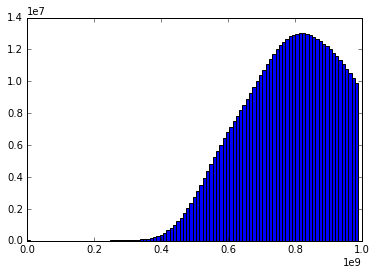

In [26]:
# Looking for a threshold to binarize
flatten_pairs = [val for sublist in pairs for val in sublist]

data = np.array([fio.read(file) for file in flatten_pairs])
all_data = np.sort(data.flatten())

plt.hist(all_data[:500401292], bins=100)
plt.show()

In [31]:
THRESHOLD = all_data[int(500401292 * 0.8)]
data = fio.read(file)
data_flat = np.sort(data.flatten())
threshold = max([THRESHOLD, data_flat[int(.8*len(data_flat))]])
binary_data = np.copy(data)
binary_data[binary_data < threshold] = 0
binary_data[binary_data >= threshold] = 1

In [ ]:
hog_pairs = []

for x in pairs:
    data = fio.read(x[0])
    data_flat = np.sort(data.flatten())
    threshold = max([THRESHOLD, data_flat[int(.8*len(data_flat))]])
    binary_data = np.copy(data)
    binary_data[binary_data < threshold] = 0
    binary_data[binary_data >= threshold] = 1
    fd1, hog_image_bin = hog(binary_data, orientations=72, pixels_per_cell=(64, 16), cells_per_block=(1, 1), visualise=True)    

    data = fio.read(x[1])
    data_flat = np.sort(data.flatten())
    threshold = max([THRESHOLD, data_flat[int(.8*len(data_flat))]])
    binary_data = np.copy(data)
    binary_data[binary_data < threshold] = 0
    binary_data[binary_data >= threshold] = 1
    fd2, hog_image_bin = hog(binary_data, orientations=72, pixels_per_cell=(64, 16), cells_per_block=(1, 1), visualise=True)    

    hog_pairs.append(list((fd1, fd2)))
    
with open('binary_hog.npy', 'wb') as outfile:
    pickle.dump(hog_pairs, outfile, protocol=pickle.HIGHEST_PROTOCOL)
    
inp = np.load('binary_hog.npy')
result_array_ON = np.empty((0, 21))
result_array_OFF = np.empty((0, 21))

hog_fd(inp)

with open('binary_hog_p.npy', 'wb') as outfile:
    pickle.dump(zip(result_array_ON, result_array_OFF), outfile, protocol=pickle.HIGHEST_PROTOCOL)

# Comparing all HOG versions

In [ ]:
for file in flatten_pairs[6:8]:
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(20,15))
    data = skimage.color.rgb2gray(fio.read(file))
    data_flat = np.sort(data.flatten())
    threshold = max([THRESHOLD, data_flat[int(.8*len(data_flat))]])
    
    const = 10 * np.log10(data)
    max_val = np.amax(const)
    fits_log = const/max_val
    
    _, log_image = hog(fits_log, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)
    
    
    binary_data = np.copy(data)
    binary_data[binary_data < threshold] = 0
    binary_data[binary_data >= threshold] = 1
    _, hog_image = hog(data, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualise=True)
    _, hog_image_bin = hog(binary_data, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualise=True)    
    ax1.imshow(data, aspect="auto")
    ax2.imshow(hog_image, aspect="auto")
    ax3.imshow(log_image, aspect="auto")
    ax4.imshow(hog_image_bin, aspect="auto")
    
    hfont = {'fontname':'Baskerville'}

    ax1.set_title("Original plot", fontsize='20', **hfont)
    ax2.set_title("HOG plot", fontsize='20', **hfont)
    ax3.set_title("Log normalized HOG plot", fontsize='20', **hfont)
    ax4.set_title("Binarized HOG plot", fontsize='20', **hfont)
    
    plt.rcParams.update({'font.size': 20})
    f.subplots_adjust(hspace=.5)
    
    plt.show()

# mod_corr_dataframe.pkl: + intensity calculations

In [19]:
header_MJD_ON = [y[3] for y in [x[0] for x in header]]
header_MJD_OFF = [y[3] for y in [x[1] for x in header]]

intensity = []
for x in pairs:
    rgbImage = fitsio.read(x[0]);
    grayImage = rgb2gray(rgbImage);
    ON_gray = sum(sum(grayImage));
    
    rgbImage = fitsio.read(x[1]);
    grayImage = rgb2gray(rgbImage);
    OFF_gray = sum(sum(grayImage));
    
    intensity.append(ON_gray - OFF_gray)

edge = np.load('hog_image_64by16_72_wb_ed_p.npy')

for x in range(len(pairs)):
    for y in range(len(edge[0])):
        r = edge[x][y]
        r[r <= 1] = 0

        r[r > 1] = 1

ON_unique = []
OFF_unique = []

for x in edge:
    diff = list(x[0] - x[1])
    ON_unique.append(diff.count(1))
    OFF_unique.append(diff.count(-1))

modified_corr = pd.read_pickle("corr_dataframe.pkl")
header = np.load('header.npy')
freq = [lip[0][0] for lip in header]
star = map(lambda x: x[:8], modified_corr.index.tolist())

del modified_corr['a_shift']
del modified_corr['u_freq_c']
del modified_corr['u_global']
del modified_corr['u_nmi']
del modified_corr['u_prmi']
del modified_corr['u_spatial']
del modified_corr['u_time_c']
del modified_corr['u_ssim']

modified_corr['a_freq_c'] = modified_corr['a_freq_c'].abs()
modified_corr['a_global'] = modified_corr['a_global'].abs()
modified_corr['a_nmi'] = modified_corr['a_nmi'].abs()
modified_corr['a_prmi'] = modified_corr['a_prmi'].abs()
modified_corr['a_spatial'] = modified_corr['a_spatial'].abs()
modified_corr['a_ssim'] = modified_corr['a_ssim'].abs()
modified_corr['a_time_c'] = modified_corr['a_time_c'].abs()

modified_corr['ON_mjd'] = pd.Series(header_MJD_ON, index=modified_corr.index)
modified_corr['OFF_mjd'] = pd.Series(header_MJD_OFF, index=modified_corr.index)
modified_corr['intensity'] = pd.Series(intensity, index=modified_corr.index)

modified_corr['ON_unique'] = pd.Series(ON_unique, index=modified_corr.index)
modified_corr['OFF_unique'] = pd.Series(OFF_unique, index=modified_corr.index)

modified_corr['freq'] = pd.Series(freq, index=df.index)
modified_corr['star'] = pd.Series(star, index=modified_corr.index)

total = sum(modified_corr['intensity'])
old_min = min(modified_corr['intensity'])
old_range = max(modified_corr['intensity'])
output = map(lambda x, r=float(old_range - old_min): ((x - old_min) / r)*10 - 1, modified_corr['intensity'].tolist())
rounded = [ round(elem, 2) for elem in output ] 
modified_corr['mod_inten'] = pd.Series(rounded, index=modified_corr.index)

with open('mod_corr_dataframe.pkl', 'wb') as outfile:
    pickle.dump(modified_corr, outfile, protocol=pickle.HIGHEST_PROTOCOL)

# dataframe.pkl

In [8]:
df = pd.read_pickle('comb_corr_hog.pkl')
df2 = pd.read_pickle('mod_corr_dataframe.pkl')

bigdata = pd.concat([df, df2], axis=1)

with open('dataframe.pkl', 'wb') as outfile:
    pickle.dump(bigdata, outfile, protocol=pickle.HIGHEST_PROTOCOL)